## geo_mozambique_1

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

import osmnx as ox

import fiona

import gdal

import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask

import cartopy as cp
from shapely.geometry import mapping
from pathlib import Path

import os

### Data understanding

#### Download shapefiles

In [26]:
%%bash 
# in terminal, download and unzip 10m country boundaries shapes from Natural Earth #TODO (Lee) - format long url
# wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip -P ~/Documents/projects_code/geo_mozambique/data/shapes/
# unzip ~/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.zip -d ~/Documents/projects_code/geo_mozambique/data/shapes/

In [ ]:
# specify directory where shapefiles located
shapes = '/Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.shp'

In [ ]:
# create geodataframe, a pandas-like data structure that contains a geoseries
gdf = gpd.read_file(shapes)

# inspect geodataframe
gdf.head(3)

In [ ]:
# inspect geometry
gdf.geometry[:5]

In [ ]:
# confirm coordinate reference system (CRS)
gdf.crs
# ouput is EPSG code 4326, which is WGS84

In [ ]:
# subset shape file to only include country borders of Mozambique
gdf_mozambique = gdf[gdf['ADMIN']=='Mozambique']

In [ ]:
# inspect geometry
gdf_mozambique.geometry

In [ ]:
# plot Mozambique shape file 
fig, ax = plt.subplots(figsize=(8,8))

# set aspect to equal when plotting directly with plt
ax.set_aspect('equal')
_ = gdf_mozambique.plot(ax=ax, legend=True)

In [ ]:
# alternately, use osmnx to get shapefiles from open street map as gpd geodataframe

# get area extent - a polygon - of Mozambique
mozambique_area = ox.gdf_from_place('Mozambique')
_ = ox.plot_shape(ox.project_gdf(mozambique_area))
# graph = ox.graph_from_place(place_name, which_result=2)

In [ ]:
# inspect tif file #1131100 from cyclone_idai pre-event images from 2019-03-07
%%bash
gdalinfo /vsicurl/https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif

In [ ]:
exists = os.path.isfile('foo.vrt')
if exists:
    os.system('rm foo.vrt')
    os.system('gdalbuildvrt foo.vrt /vsicurl/https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif')

In [ ]:
# un-comment to build VRT from a list of datasets
# gdalbuildvrt

In [ ]:
def get_digitalglobe_data(date):
    """Get data from digital globe open data"""
    import gdal
    exists = os.path.isfile('foo.vrt')
    if exists:
        os.system('rm foo.vrt')
        os.system('gdalbuildvrt foo.vrt /vsicurl/http://opendata.digitalglobe.com/cyclone-kenneth/pre-event/)

In [3]:
# get data for cyclone idai

In [4]:
# build a VRT (Virtual Dataset) that is a mosaic of the list of input GDAL datasets. 
# OGR Virtual Format is a driver that transforms features read from other drivers based on criteria specified in an XML control file. 
# Primarily used to derive spatial layers from flat tables with spatial information in attribute columns.
# Also be used to associate coordinate system information with a datasource, merge layers from different datasources 
# into a single data source, or even just to provide an anchor file for access to non-file oriented datasources.

#### Open file

- a dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. 
- all band arrays of a dataset have the same number of rows and columns. 
- the variable represented by the example dataset’s sole band is Level-1 digital numbers (DN) for the Landsat 8 operational Land Imager (OLI) band 4 (wavelengths between 640-670 nanometers). 
- these values can be scaled to radiance or reflectance values. The array of DN values is 7731 columns wide and 7871 rows high.

In [23]:
# use rasterio, with gdal under the hood, to open dataset object from path to raster file
dataset = rio.open('https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif')

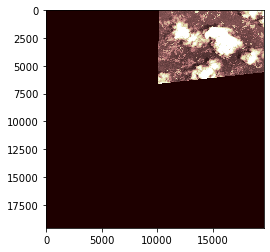

In [22]:
# plot
plt.imshow(dataset.read(1), cmap='pink')
# plt.image.AxesImage object at 0x...>
plt.show()

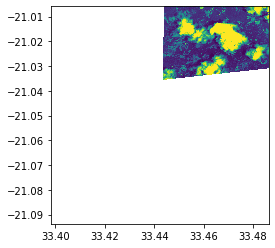

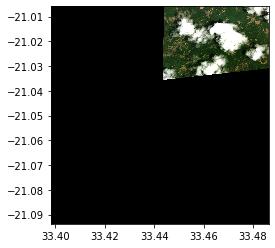

In [24]:
# plot
show(dataset)
# plt.axes._subplots.AxesSubplot object at 0x...>
show(dataset.read(), transform=dataset.transform)
# plt.axes._subplots.AxesSubplot object at 0x...>

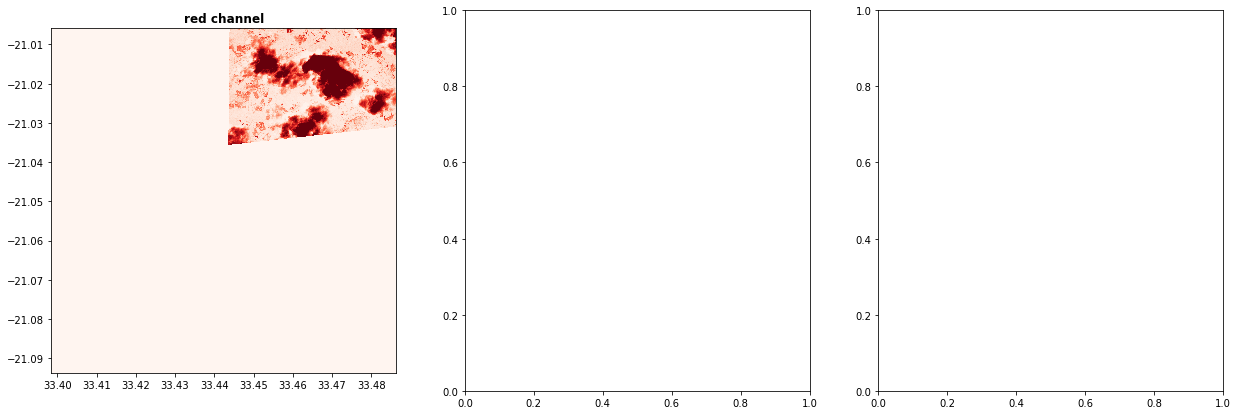

In [32]:
# plots of three bands
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((dataset, 1), ax=axr, cmap='Reds', title='red channel')

# plt.axes._subplots.AxesSubplot
# show((dataset, 2), ax=axg, cmap='Greens', title='green channel')

# plt.axes._subplots.AxesSubplot
# show((dataset, 3), ax=axb, cmap='Blues', title='blue channel')

# plt.axes._subplots.AxesSubplot

# plt.show()

In [ ]:
# plot color bands histogram
show_hist(
     src, bins=50, lw=0.0, stacked=False, alpha=0.3,
     histtype='stepfilled', title="Histogram")

In [ ]:
# plot color bands and associated histogram
fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
show(dataset, ax=axrgb)
plt.axes._subplots.AxesSubplot
show_hist(dataset, bins=50, histtype='stepfilled',
           lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()


In [6]:
# inspect width
dataset.width

19584

In [7]:
#inspect height
dataset.height

19584

In [11]:
# return spatial bounding box by mapping raster image elements (pixels) map to regions on earth
dataset.bounds
# the image extends from 33.3984375 to 33.486328125 and 21.005859375 to -21.09375 

BoundingBox(left=33.3984375, bottom=-21.09375, right=33.486328125, top=-21.005859375)

In [12]:
# the bounding box values derive from the the affine transformation matrix:
dataset.transform
# affine transformation matrix maps pixel locations in (row, col) coordinates
# to (x, y) spatial positions.

Affine(4.48787913602941e-06, 0.0, 33.3984375,
       0.0, -4.48787913602941e-06, -21.005859375)

In [13]:
# calculate the spatial position of the upper left corner of dataset
# by taking product of the Affine matrix and the row and column coordinates ((0, 0),)
of the upper left corner of the dataset is the spatial position of the upper left corner
dataset.transform * (0, 0)

(33.3984375, -21.005859375)

In [ ]:
# the position of the lower right corner is:
dataset.transform * (dataset.width, dataset.height)

In [14]:
# these coordinate values are relative to the origin of the dataset’s CRS
dataset.crs

CRS.from_epsg(4326)

In [ ]:
# the CRS and affine transform georeference a raster dataset and make comparable to other datasets

In [15]:
# inspect number of bands, indexed by convention from 1, not 0
dataset.indexes

(1, 2, 3)

In [19]:
# read band 1
band_1 = dataset.read(1)

# return np array
band_1

array([[  0,   0,   0, ..., 242, 242, 241],
       [  0,   0,   0, ..., 242, 246, 247],
       [  0,   0,   0, ..., 245, 247, 246],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

### Make raster using shapefile

In [33]:
# with fiona.open(mozambique_area, "r") as shapefile:
#     features = [feature["geometry"] for feature in shapefile]